In [1]:
import sys 
sys.path.insert(0,'../')

%matplotlib inline
from scripts.Deblender import Deblend
from scripts.utils import listdir_fullpath

import numpy as np
import os

import matplotlib.pyplot as plt

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import tensorflow as tf
import tensorflow_probability as tfp
tf.get_logger().setLevel('ERROR')

2022-05-04 16:29:34.483913: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-05-04 16:29:34.484088: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import seaborn as sns
sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

In [3]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 100
max_number = 60
batch_size = 1
max_shift = 44
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("Rubin")
seed=3

import galsim 
galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, maxshift=max_shift, stamp_size=stamp_size, seed=seed)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="parametric",
    seed=seed,
)

In [4]:
def crop_image(image, pos, cutout_size):
    """
    crops a portion of the image.
    
    Parameters
    ----------
    image:
    
    pos:
    
    cutout_size: float
        cutout size in arcminutes
    
    Returns
    -------
    cropped image
    """
    
    cutout_pixel_size = int(cutout_size * 5)
    
    x_crop_start = int(pos[0] - (cutout_pixel_size-1)/2)
    x_crop_end = int(pos[0] + (cutout_pixel_size-1)/2)
    
    y_crop_start = int(pos[1] - (cutout_pixel_size-1)/2)
    y_crop_end = int(pos[1] + (cutout_pixel_size-1)/2)
    
    #print(np.shape(image))
    #print(pos)
    #print(x_crop_start)
    #print(x_crop_end+1)
    cropped_image = image[2, x_crop_start:x_crop_end+1, y_crop_start:y_crop_end+1]
    
    #print(np.shape(crop_image))
    return cropped_image.copy()


In [5]:
blend = next(draw_generator)

blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])

(6, 500, 500)

input_image


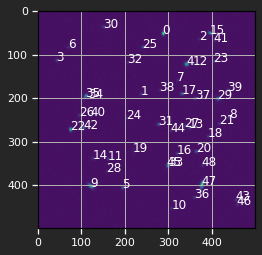

In [6]:
print("input_image")
plt.imshow(blend['blend_images'][0, 2])
for i in range(len(blend['blend_list'][0])):
    plt.text(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], str(i))

input_image


/pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  if __name__ == '__main__':


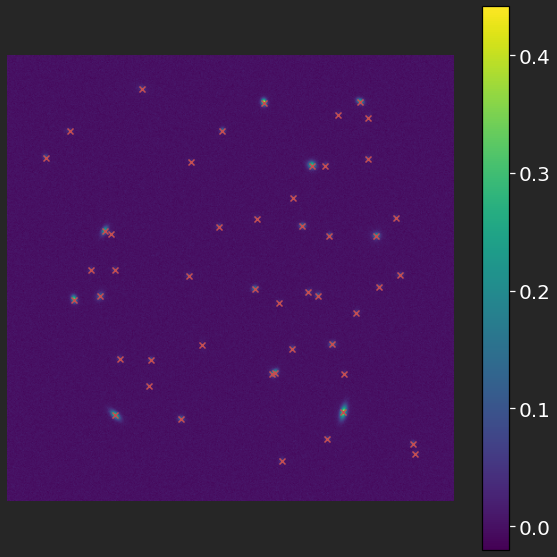

In [7]:
print("input_image")
fig=plt.figure(figsize=(10,10))
ax=fig.gca()
im1 = ax.imshow(blend['blend_images'][0, 2]/80000)
for i in range(len(blend['blend_list'][0])):
    plt.scatter(blend['blend_list'][0]['x_peak'][i], 
                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
    #plt.text(blend['blend_list'][0]['x_peak'][i]-1, blend['blend_list'][0]['y_peak'][i]-1, str(i), c='black', fontsize=15)
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("input field")


In [8]:
tf.get_logger().setLevel('ERROR')

detected_positions = []
for i in range(len(blend['blend_list'][0])):
    detected_positions.append([blend['blend_list'][0]['y_peak'][i], blend['blend_list'][0]['x_peak'][i]])

deb = Deblend(blend['blend_images'][0]/80000, 
              detected_positions,
              latent_dim=8, 
              num_components=len(blend['blend_list'][0]), 
              use_likelihood=True, 
              max_iter=300)

2022-05-04 16:30:56.639357: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-05-04 16:30:56.639574: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-04 16:30:56.639719: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-05-04 16:30:56.641186: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 16:30:56.

In [9]:
#deb.run_debvader()

In [10]:
#fig, ax = plt.subplots(len(blend['blend_list'][0]), 3, figsize=(5*3,5*len(blend['blend_list'][0])))

#for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
#     im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9))
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 0].set_title("ground truth")
#     ax[i, 0].scatter(22, 22, c="r", marker="x")

#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 1].set_title("predicted")
    
#     im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9) - deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im3, ax=ax[i, 2])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 2].set_title("actual - predicted")
    
# plt.show()

In [11]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.gca()
# padding_infos = deb.get_padding_infos()
# residual = deb.compute_residual(blend['blend_images'][0]/80000, use_scatter_and_sub=True).numpy()
# #residual = np.transpose(deb.postage_stamp, 
# im1 = ax.imshow(residual[:, :, 2])
# cbar =fig.colorbar(im1, ax=ax)
# cbar.ax.tick_params(labelsize=20)
# plt.savefig("residual")

In [13]:
tf.config.run_functions_eagerly(False)
convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(atol=.0000015*45*45*len(blend['blend_list'][0])*3, min_num_steps=50, window_size=15)
#convergence_criterion = None
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.04, decay_steps=8, decay_rate=0.9, staircase=True)
optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler)

deb(convergence_criterion, optimizer=optimizer)


--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 49
Dimensions of latent space: 8
--- Gradient descent complete ---

Time taken for gradient descent: 107.55749940872192


/pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  app.launch_new_instance()


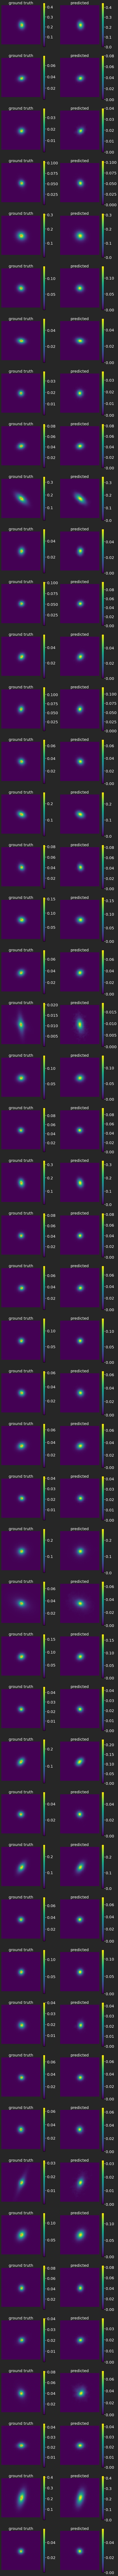

In [14]:
fig, ax = plt.subplots(len(blend['blend_list'][0]), 2, figsize=(5*2,5*len(blend['blend_list'][0])))

for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
    im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9))
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=20)
    ax[i, 0].set_title("ground truth", fontsize=20)
    ax[i, 0].scatter(22, 22, c="r", marker="x")
    ax[i, 0].axis('off')


    im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=20)
    ax[i, 1].set_title("predicted", fontsize=20)
    ax[i, 1].axis('off')

    
#     im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9) - deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im3, ax=ax[i, 2])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 2].set_title("actual - predicted")
#     plt.axis('off')

plt.savefig("MAP_predictions")
plt.show()

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


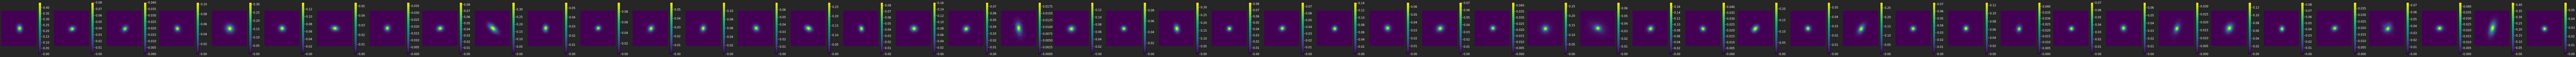

In [15]:
fig, ax = plt.subplots(1, len(blend['blend_list'][0]), figsize=(5*len(blend['blend_list'][0]), 5*1))
for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]

    im2 = ax[i].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i])
    cbar.ax.tick_params(labelsize=15)
    ax[i].axis("off")
    #ax[i].set_title("predicted")
plt.savefig("predictions")

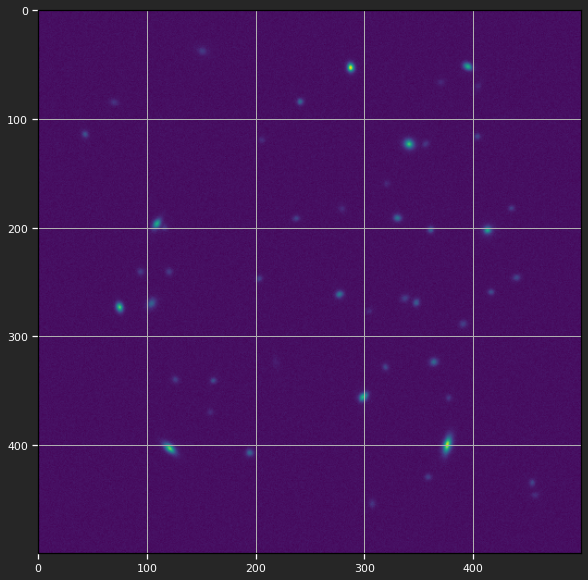

In [16]:
fig = plt.figure(figsize=(10,10))
plt.imshow(blend['blend_images'][0][1])

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  if __name__ == '__main__':


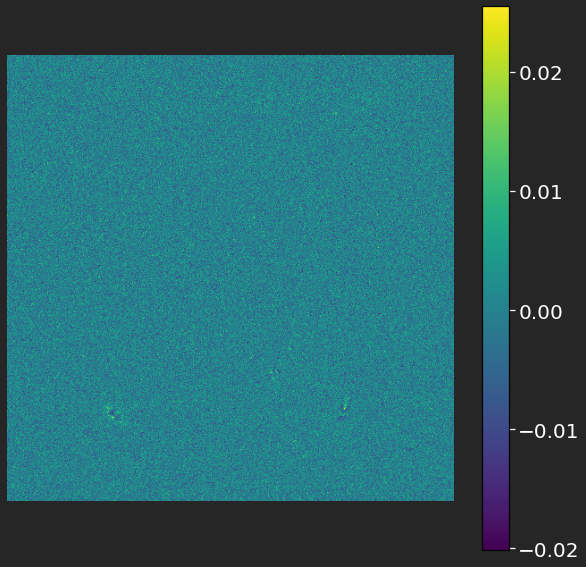

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
tf.config.run_functions_eagerly(True)

padding_infos = deb.get_padding_infos()
residual = deb.compute_residual(blend['blend_images'][0]/80000, use_scatter_and_sub=True).numpy()
#residual = np.transpose(deb.postage_stamp, 
im1 = ax.imshow(residual[:, :, 2])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("residual")

#for i in range(len(blend['blend_list'][0])):
    #plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

tf.Tensor(
[749998.8  763944.44 754240.94 752922.44 755056.   754781.25 755242.25
 754827.75 754665.56 753786.06 753588.1  752974.75 753118.44 752770.9
 752785.94 753069.8  752610.75 752385.8  752274.1  752240.1  752136.2
 752143.06 752084.56 752383.94 752105.9  752188.   751848.   751923.75
 751790.8  751806.   751719.06 751773.7  751623.94 751613.9  751366.2
 751498.9  751337.5  751337.9  751278.94 751369.8  751280.25 751320.1
 751122.44 751205.5  751080.75 751134.1  751043.06 751164.3  751024.94
 751126.44 751005.5  751043.6  750928.3  750972.   750910.75 751008.2
 750916.2  750976.9  750882.   750915.5  750811.7  750867.9  750810.25
 750910.25 750807.   750877.06 750757.8  750771.2  750730.7  750764.9
 750710.1  750775.3  750690.7  750769.56 750681.75 750639.25 750630.7
 750615.06 750617.56 750658.6  750604.5  750631.94 750563.6  750558.8
 750551.8  750544.5  750545.75 750548.8  750519.3  750566.25 750478.9
 750470.25 750448.4  750466.8  750425.7  750474.8  750453.3  750466.3
 7504

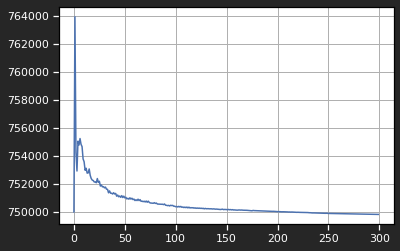

In [18]:
print(deb.results)
plt.plot(deb.results)

In [19]:
from scripts.metrics import compute_reconstruction_metrics
from scripts.extraction import extract_cutouts

In [20]:
field_size = np.shape(blend['isolated_images'][0][i])[1]

In [21]:
field_image=blend['blend_images'][0]

In [22]:
cutouts, list_idx = extract_cutouts(field_image=blend['blend_images'][0]/80000, galaxy_distances_to_center=np.array(detected_positions)-int(field_size/2), cutout_size=45, channel_last=False)

In [23]:
np.shape(cutouts)

(49, 45, 45, 6)

In [24]:
np.shape(deb.components)

(49, 45, 45, 6)

In [25]:
results=compute_reconstruction_metrics(deb.components, cutouts)

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/python3.7/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


In [28]:
print(results.keys())

dict_keys(['mse', 'psnr', 'ssim'])


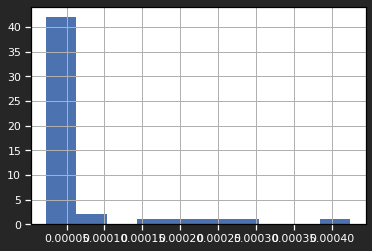

In [29]:
plt.hist(results["mse"]);

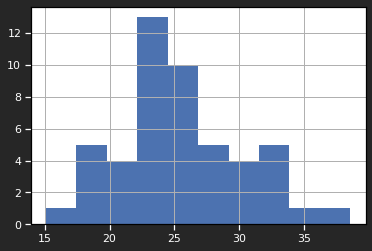

In [31]:
plt.hist(results["psnr"]);

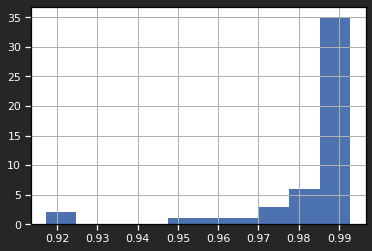

In [32]:
plt.hist(results["ssim"]);